# All of our code is a the bottom labeled "OUR WORK"

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

## 3. Tackle the Titanic dataset

The goal is to predict whether or not a passenger survived based on attributes such as their age, sex, passenger class, where they embarked and so on.

First, login to [Kaggle](https://www.kaggle.com/) and go to the [Titanic challenge](https://www.kaggle.com/c/titanic) to download `train.csv` and `test.csv`. Save them to the `datasets/titanic` directory.

Next, let's load the data:

In [3]:
import pandas as pd
import os

def load_titanic_data(filename):
    csv_path = os.path.join(filename)
    return pd.read_csv(csv_path)

In [4]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

The data is already split into a training set and a test set. However, the test data does *not* contain the labels: your goal is to train the best model you can using the training data, then make your predictions on the test data and upload them to Kaggle to see your final score.

Let's take a peek at the top few rows of the training set:

In [5]:
train_data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

The attributes have the following meaning:
* **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic

Let's get more info to see how much data is missing:

In [6]:

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Okay, the **Age**, **Cabin** and **Embarked** attributes are sometimes null (less than 891 non-null), especially the **Cabin** (77% are null). We will ignore the **Cabin** for now and focus on the rest. The **Age** attribute has about 19% null values, so we will need to decide what to do with them. Replacing null values with the median age seems reasonable.

The **Name** and **Ticket** attributes may have some value, but they will be a bit tricky to convert into useful numbers that a model can consume. So for now, we will ignore them.

Let's take a look at the numerical attributes:

In [7]:
train_data.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

* Yikes, only 38% **Survived**. :(  That's close enough to 40%, so accuracy will be a reasonable metric to evaluate our model.
* The mean **Fare** was £32.20, which does not seem so expensive (but it was probably a lot of money back then).
* The mean **Age** was less than 30 years old.

Let's check that the target is indeed 0 or 1:

In [8]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Now let's take a quick look at all the categorical attributes:

In [9]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [10]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [11]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

The Embarked attribute tells us where the passenger embarked: C=Cherbourg, Q=Queenstown, S=Southampton.

Now let's build our preprocessing pipelines. We will reuse the `DataframeSelector` we built in the previous chapter to select specific attributes from the `DataFrame`:

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

Let's build the pipeline for the numerical attributes:

**Warning**: Since Scikit-Learn 0.20, the `sklearn.preprocessing.Imputer` class was replaced by the `sklearn.impute.SimpleImputer` class.

In [13]:
from sklearn.pipeline import Pipeline
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ("imputer", SimpleImputer(strategy="median")),
    ])
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

We will also need an imputer for the string categorical columns (the regular `SimpleImputer` does not work on those):

In [14]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

**Warning**: earlier versions of the book used the `LabelBinarizer` or `CategoricalEncoder` classes to convert each categorical value to a one-hot vector. It is now preferable to use the `OneHotEncoder` class. Since Scikit-Learn 0.20 it can handle string categorical inputs (see [PR #10521](https://github.com/scikit-learn/scikit-learn/issues/10521)), not just integer categorical inputs. If you are using an older version of Scikit-Learn, you can import the new version from `future_encoders.py`:

In [15]:
try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20

Now we can build the pipeline for the categorical attributes:

In [16]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [17]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

Finally, let's join the numerical and categorical pipelines:

In [18]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

Cool! Now we have a nice preprocessing pipeline that takes the raw data and outputs numerical input features that we can feed to any Machine Learning model we want.

In [19]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

Let's not forget to get the labels:

In [20]:
y_train = train_data["Survived"]

We are now ready to train a classifier. Let's start with an `SVC`:

In [21]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Great, our model is trained, let's use it to make predictions on the test set:

In [22]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

And now we could just build a CSV file with these predictions (respecting the format excepted by Kaggle), then upload it and hope for the best. But wait! We can do better than hope. Why don't we use cross-validation to have an idea of how good our model is?

In [23]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7365250822835092

Okay, over 73% accuracy, clearly better than random chance, but it's not a great score. Looking at the [leaderboard](https://www.kaggle.com/c/titanic/leaderboard) for the Titanic competition on Kaggle, you can see that you need to reach above 80% accuracy to be within the top 10% Kagglers. Some reached 100%, but since you can easily find the [list of victims](https://www.encyclopedia-titanica.org/titanic-victims/) of the Titanic, it seems likely that there was little Machine Learning involved in their performance! ;-) So let's try to build a model that reaches 80% accuracy.

Let's try a `RandomForestClassifier`:

In [24]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8149526160481217

That's much better!

Instead of just looking at the mean accuracy across the 10 cross-validation folds, let's plot all 10 scores for each model, along with a box plot highlighting the lower and upper quartiles, and "whiskers" showing the extent of the scores (thanks to Nevin Yilmaz for suggesting this visualization). Note that the `boxplot()` function detects outliers (called "fliers") and does not include them within the whiskers. Specifically, if the lower quartile is $Q_1$ and the upper quartile is $Q_3$, then the interquartile range $IQR = Q_3 - Q_1$ (this is the box's height), and any score lower than $Q_1 - 1.5 \times IQR$ is a flier, and so is any score greater than $Q3 + 1.5 \times IQR$.

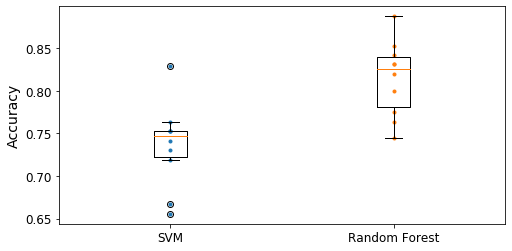

In [25]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

To improve this result further, you could:
* Compare many more models and tune hyperparameters using cross validation and grid search,
* Do more feature engineering, for example:
  * replace **SibSp** and **Parch** with their sum,
  * try to identify parts of names that correlate well with the **Survived** attribute (e.g. if the name contains "Countess", then survival seems more likely),
* try to convert numerical attributes to categorical attributes: for example, different age groups had very different survival rates (see below), so it may help to create an age bucket category and use it instead of the age. Similarly, it may be useful to have a special category for people traveling alone since only 30% of them survived (see below).

In [26]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

Survived
AgeBucket          
0.0        0.576923
15.0       0.362745
30.0       0.423256
45.0       0.404494
60.0       0.240000
75.0       1.000000

In [27]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

Survived
RelativesOnboard          
0                 0.303538
1                 0.552795
2                 0.578431
3                 0.724138
4                 0.200000
5                 0.136364
6                 0.333333
7                 0.000000
10                0.000000

# OUR WORK

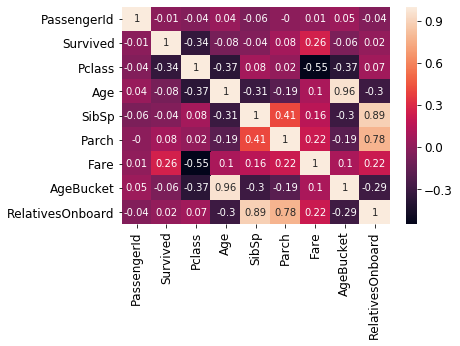

In [28]:
import seaborn as sns 
# compute the pair wise correlation for all columns  
correlation_matrix = train_data.corr().round(2)


# use the heatmap function from seaborn to plot the correlation matrix
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

In [29]:
correlation_matrix["Survived"]

PassengerId        -0.01
Survived            1.00
Pclass             -0.34
Age                -0.08
SibSp              -0.04
Parch               0.08
Fare                0.26
AgeBucket          -0.06
RelativesOnboard    0.02
Name: Survived, dtype: float64

In [30]:
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)
print("% of women who survived: ", rate_women)

% of women who survived:  0.7420382165605095


In [31]:
train_data["Women"] = train_data.Sex == 'female'

In [32]:
train_data

PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
5              6         0       3   
6              7         0       1   
7              8         0       3   
8              9         1       3   
9             10         1       2   
10            11         1       3   
11            12         1       1   
12            13         0       3   
13            14         0       3   
14            15         0       3   
15            16         1       2   
16            17         0       3   
17            18         1       2   
18            19         0       3   
19            20         1       3   
20            21         0       2   
21            22         1       2   
22            23         1       3   
23            24         1       1   
24            25         0       3   
25            26         1       3   
26            27         0       3   
27            28         0       1   
28            29         1       3   
29            30         0       3   
..           ...       ...     ...   
861          862         0       2   
862          863         1       1   
863          864         0       3   
864          865         0       2   
865          866         1       2   
866          867         1       2   
867          868         0       1   
868          869         0       3   
869          870         1       3   
870          871         0       3   
871          872         1       1   
872          873         0       1   
873          874         0       3   
874          875         1       2   
875          876         1       3   
876          877         0       3   
877          878         0       3   
878          879         0       3   
879          880         1       1   
880          881         1       2   
881          882         0       3   
882          883         0       3   
883          884         0       2   
884          885         0       3   
885          886         0       3   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
5                                     Moran, Mr. James    male   NaN      0   
6                              McCarthy, Mr. Timothy J    male  54.0      0   
7                       Palsson, Master. Gosta Leonard    male   2.0      3   
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  female  27.0      0   
9                  Nasser, Mrs. Nicholas (Adele Achem)  female  14.0      1   
10                     Sandstrom, Miss. Marguerite Rut  female   4.0      1   
11                            Bonnell, Miss. Elizabeth  female  58.0      0   
12                      Saundercock, Mr. William Henry    male  20.0      0   
13                         Andersson, Mr. Anders Johan    male  39.0      1   
14                Vestrom, Miss. Hulda Amanda Adolfina  female  14.0      0   
15                    Hewlett, Mrs. (Mary D Kingcome)   female  55.0      0   
16                                Rice, Master. Eugene    male   2.0      4   
17                        Williams, Mr. Charles Eugene    male   NaN      0   
18   Vander Planke, Mrs. Julius (Emelia Maria Vande...  female  31.0      1   
19                             Masselmani, Mrs. Fatima  female   NaN

In [33]:

correlation_matrix = train_data.corr().round(2)
correlation_matrix["Survived"]

PassengerId        -0.01
Survived            1.00
Pclass             -0.34
Age                -0.08
SibSp              -0.04
Parch               0.08
Fare                0.26
AgeBucket          -0.06
RelativesOnboard    0.02
Women               0.54
Name: Survived, dtype: float64

In [34]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).corr().round(2)

Survived
AgeBucket                   
0.0       Survived       1.0
15.0      Survived       1.0
30.0      Survived       1.0
45.0      Survived       1.0
60.0      Survived       1.0
75.0      Survived       NaN

In [35]:
test_data["AgeBucket"] = test_data["Age"] // 15 * 15

In [36]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [37]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., 0., 1.],
       [1., 0., 0., 1., 0.],
       [0., 0., 1., 1., 0.],
       ...,
       [0., 0., 1., 1., 0.],
       [1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 1.]])

In [38]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [39]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[22.,  1.,  0., ...,  1.,  0.,  1.],
       [38.,  1.,  0., ...,  0.,  1.,  0.],
       [26.,  0.,  0., ...,  1.,  1.,  0.],
       ...,
       [28.,  1.,  2., ...,  1.,  1.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       [32.,  0.,  0., ...,  1.,  0.,  1.]])

In [40]:
y_train = train_data["Survived"]

In [41]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [42]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

In [43]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7353262966746114

In [44]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8183861082737488

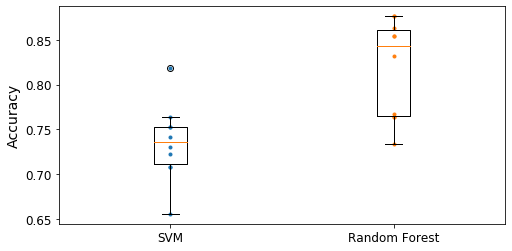

In [45]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

In [46]:
train_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363

In [47]:
train_data.isnull().sum()[train_data.isnull().sum()>0]

Age          177
Cabin        687
Embarked       2
AgeBucket    177
dtype: int64

In [48]:
train_data.Cabin = train_data.Cabin.fillna("unknown")

In [49]:
train_data['title'] = train_data.Name.apply(lambda x: x.split('.')[0].split(',')[1].strip())
test_data['title'] = test_data.Name.apply(lambda x: x.split('.')[0].split(',')[1].strip())

In [50]:
newtitles={
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"}

In [51]:
train_data['title']=train_data.title.map(newtitles)
test_data['title']=test_data.title.map(newtitles)

In [52]:
train_data.groupby(['title','Sex']).Age.mean()

title    Sex   
Master   male       4.574167
Miss     female    21.804054
Mr       male      32.368090
Mrs      female    35.718182
Officer  female    49.000000
         male      46.562500
Royalty  female    40.500000
         male      42.333333
Name: Age, dtype: float64

In [53]:
def newage (cols):
    title=cols[0]
    Sex=cols[1]
    Age=cols[2]
    if pd.isnull(Age):
        if title=='Master' and Sex=="male":
            return 4.57
        elif title=='Miss' and Sex=='female':
            return 21.8
        elif title=='Mr' and Sex=='male': 
            return 32.37
        elif title=='Mrs' and Sex=='female':
            return 35.72
        elif title=='Officer' and Sex=='female':
            return 49
        elif title=='Officer' and Sex=='male':
            return 46.56
        elif title=='Royalty' and Sex=='female':
            return 40.50
        else:
            return 42.33
    else:
        return Age 

In [54]:
train_data.Age=train_data[['title','Sex','Age']].apply(newage, axis=1)
test_data.Age=test_data[['title','Sex','Age']].apply(newage, axis=1)

In [55]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

Survived
AgeBucket          
0.0        0.573171
15.0       0.388889
30.0       0.339031
45.0       0.400000
60.0       0.240000
75.0       1.000000

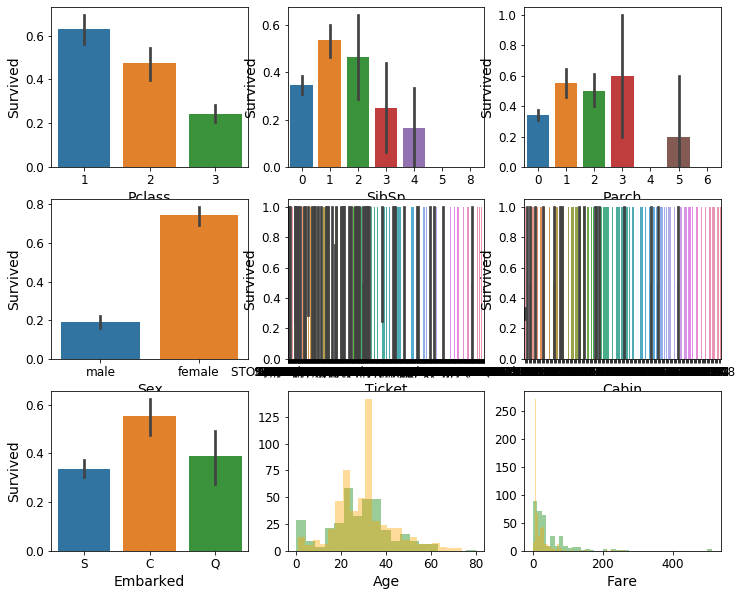

In [56]:
#warnings.filterwarnings(action="ignore")
plt.figure(figsize=[12,10])
plt.subplot(3,3,1)
sns.barplot('Pclass','Survived',data=train_data)
plt.subplot(3,3,2)
sns.barplot('SibSp','Survived',data=train_data)
plt.subplot(3,3,3)
sns.barplot('Parch','Survived',data=train_data)
plt.subplot(3,3,4)
sns.barplot('Sex','Survived',data=train_data)
plt.subplot(3,3,5)
sns.barplot('Ticket','Survived',data=train_data)
plt.subplot(3,3,6)
sns.barplot('Cabin','Survived',data=train_data)
plt.subplot(3,3,7)
sns.barplot('Embarked','Survived',data=train_data)
plt.subplot(3,3,8)
sns.distplot(train_data[train_data.Survived==1].Age, color='green', kde=False)
sns.distplot(train_data[train_data.Survived==0].Age, color='orange', kde=False)
plt.subplot(3,3,9)
sns.distplot(train_data[train_data.Survived==1].Fare, color='green', kde=False)
sns.distplot(train_data[train_data.Survived==0].Fare, color='orange', kde=False)

In [57]:
random_forest = RandomForestClassifier(n_estimators=100)
x_fit = random_forest.fit(X_train, y_train)
random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
acc_random_forest

97.98

In [58]:
random_forest = RandomForestClassifier(n_estimators=100)
x_fit = random_forest.fit(X_train, y_train)
Y_pred = random_forest.predict(X_test)
pred = x_fit.predict(X_test)
x_fit.score(X_test, pred)

1.0

In [59]:
output = pd.DataFrame({'PassengerId':test_data['PassengerId'], 'Survived':pred})

In [60]:
output.to_csv('submission.csv', index=False)

In [61]:
train_data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare    Cabin Embarked  AgeBucket  \
0      0         A/5 21171   7.2500  unknown        S       15.0   
1      0          PC 17599  71.2833      C85        C       30.0   
2      0  STON/O2. 3101282   7.9250  unknown        S       15.0   
3      0            113803  53.1000     C123        S       30.0   
4      0            373450   8.0500  unknown        S       30.0   

   RelativesOnboard  Women title  
0                 1  False    Mr  
1                 1   True   Mrs  
2                 0   True  Miss  
3                 1   True   Mrs  
4                 0  False    Mr

In [62]:
train_data.Fare=train_data.Fare.fillna(train_data.Fare.mean())
test_data.Fare=test_data.Fare.fillna(train_data.Fare.mean())

In [63]:
train_data.Cabin=train_data.Cabin.fillna("unknow")
test_data.Cabin=test_data.Cabin.fillna("unknow")

In [64]:
train_data.Embarked=train_data.Embarked.fillna(train_data.Embarked.mode()[0])
test_data.Embarked=test_data.Embarked.fillna(train_data.Embarked.mode()[0])

In [65]:
train_data.Age=train_data[['title','Sex','Age']].apply(newage, axis=1)
test_data.Age=test_data[['title','Sex','Age']].apply(newage, axis=1)

Feature engineering

In [66]:
train_data['Relatives']=train_data.SibSp+train_data.Parch
test_data['Relatives']=test_data.SibSp+test_data.Parch

train_data['Ticket2']=train_data.Ticket.apply(lambda x : len(x))
test_data['Ticket2']=test_data.Ticket.apply(lambda x : len(x))

train_data['Cabin2']=train_data.Cabin.apply(lambda x : len(x))
test_data['Cabin2']=test_data.Cabin.apply(lambda x : len(x))

train_data['Name2']=train_data.Name.apply(lambda x: x.split(',')[0].strip())
test_data['Name2']=test_data.Name.apply(lambda x: x.split(',')[0].strip())

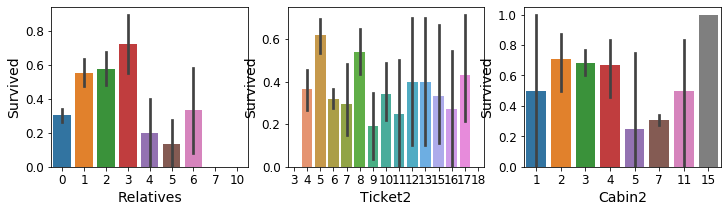

In [67]:

plt.figure(figsize=[12,10])
plt.subplot(3,3,1)
sns.barplot('Relatives','Survived',data=train_data)
plt.subplot(3,3,2)
sns.barplot('Ticket2','Survived',data=train_data)
plt.subplot(3,3,3)
sns.barplot('Cabin2','Survived',data=train_data)

In [68]:
test_data.isnull().sum()[train_data.isnull().sum()>0]

Series([], dtype: int64)

In [69]:
train_data.drop([ 'Name','Cabin'],axis=1,inplace=True)
test_data.drop(['Name','Cabin'],axis=1,inplace=True)

In [70]:
titanic=pd.concat([train_data, test_data], sort=False)
titanic=pd.get_dummies(titanic)

train=titanic[:len(train_data)]
test=titanic[len(train_data):]

train.Survived=train.Survived.astype('int')

C:\Users\naomi\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [71]:

train.Survived.dtype

dtype('int32')

In [72]:
xtrain=train.drop("Survived",axis=1)
ytrain=train['Survived']
xtest=test.drop("Survived", axis=1)

In [73]:

from sklearn.model_selection import GridSearchCV

RF=RandomForestClassifier(random_state=1)
PRF=[{'n_estimators':[10,100],'max_depth':[3,6],'criterion':['gini','entropy']}]
GSRF=GridSearchCV(estimator=RF, param_grid=PRF, scoring='accuracy',cv=2)
scores_rf=cross_val_score(GSRF,xtrain,ytrain,scoring='accuracy',cv=5)

In [74]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8183861082737488

In [75]:
random_forest = RandomForestClassifier(n_estimators=100)
x_fit = random_forest.fit(X_train, y_train)
Y_pred = random_forest.predict(X_test)
pred = x_fit.predict(X_test)
x_fit.score(X_test, pred)

1.0

In [76]:
output = pd.DataFrame({'PassengerId':test_data['PassengerId'], 'Survived':pred})

In [77]:
output.to_csv('submission.csv', index=False)

# Our Work / CLEANED! \\

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [3]:
import pandas as pd
import os

def load_titanic_data(filename):
    csv_path = os.path.join(filename)
    return pd.read_csv(csv_path)

In [4]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

## Cleaning and Preprocessing the Data

### For finding the age

In [5]:
train_data['title'] = train_data.Name.apply(lambda x: x.split('.')[0].split(',')[1].strip())
test_data['title'] = test_data.Name.apply(lambda x: x.split('.')[0].split(',')[1].strip())

In [6]:
newtitles={
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"}

In [7]:
train_data['title']=train_data.title.map(newtitles)
test_data['title']=test_data.title.map(newtitles)

In [8]:
def newage (cols):
    title=cols[0]
    Sex=cols[1]
    Age=cols[2]
    if pd.isnull(Age):
        if title=='Master' and Sex=="male":
            return 4.57
        elif title=='Miss' and Sex=='female':
            return 21.8
        elif title=='Mr' and Sex=='male': 
            return 32.37
        elif title=='Mrs' and Sex=='female':
            return 35.72
        elif title=='Officer' and Sex=='female':
            return 49
        elif title=='Officer' and Sex=='male':
            return 46.56
        elif title=='Royalty' and Sex=='female':
            return 40.50
        else:
            return 42.33
    else:
        return Age 

In [9]:
train_data.Age=train_data[['title','Sex','Age']].apply(newage, axis=1)
test_data.Age=test_data[['title','Sex','Age']].apply(newage, axis=1)

In [10]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
test_data["AgeBucket"] = test_data["Age"] 
#train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

### Cleaning Fare

In [11]:
train_data.Fare=train_data.Fare.fillna(train_data.Fare.mean())
test_data.Fare=test_data.Fare.fillna(train_data.Fare.mean())

### Cleaning the Cabin Value

In [12]:
train_data.Cabin=train_data.Cabin.fillna("unknow")
test_data.Cabin=test_data.Cabin.fillna("unknow")

### Cleaning the Embarked

In [13]:
train_data.Embarked=train_data.Embarked.fillna(train_data.Embarked.mode()[0])
test_data.Embarked=test_data.Embarked.fillna(train_data.Embarked.mode()[0])

## Pipeline

In [14]:
from sklearn.pipeline import Pipeline
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [16]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [17]:
try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20

Pipeline taking into account: age, families, fare

In [18]:
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ("imputer", SimpleImputer(strategy="median")),
    ])
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [21.8   ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

Another pipeline, taking into account: Class, sex, location, age bucket

In [19]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [20]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

Pipeline to combine cat and num

In [21]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [22]:
X_train = preprocess_pipeline.fit_transform(train_data)
y_train = train_data["Survived"]

#X_test = preprocess_pipeline.transform(test_data)

## SVC Classifier

In [23]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [24]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

In [25]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.739782658041085

## Random Forest Classifier

Have a score of 81%

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8138295880149812

In [27]:
x_fit = forest_clf.fit(X_train, y_train)
Y_pred = forest_clf.predict(X_test)
pred = x_fit.predict(X_test)
x_fit.score(X_test, pred)

1.0

## Decision Tree Classifier

Kaggle Score: 0.72248

In [28]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
Y_pred = decision_tree.predict(X_test)
accuracy = round(decision_tree.score(X_train, y_train) * 100, 2)

print("Model Accuracy: ",accuracy)

Model Accuracy:  98.2


In [29]:
decision_tree_score = cross_val_score(decision_tree, X_train, y_train, cv=10)
decision_tree_score.mean()

0.7834791737600726

In [30]:
x_fit = decision_tree.fit(X_train, y_train)
Y_pred = decision_tree.predict(X_test)
pred = x_fit.predict(X_test)
x_fit.score(X_test, pred)

1.0

# K-Nearest Neighbors
Kaggle Score: 0.65550

In [34]:
from sklearn.neighbors import KNeighborsClassifier

neighbors = KNeighborsClassifier()
x_fit = neighbors.fit(X_train, y_train)
Y_pred = neighbors.predict(X_test)
accuracy = round(neighbors.score(X_train, y_train)*100,2)
pred = x_fit.predict(X_test)
print("Model Accuracy: ", accuracy)

Model Accuracy:  81.37


In [32]:
neighbors_score = cross_val_score(neighbors, X_train, y_train, cv=10)
neighbors_score.mean()

0.715088809442742

# Outputting 

In [35]:
output = pd.DataFrame({'PassengerId':test_data['PassengerId'], 'Survived':pred})
output.to_csv('submission.csv', index=False)